# What this code does

This code takes the list of basins that have complete data in a specific interval, and uses that to take a subsample of catchments that follow the koppen geiger climate types proportion in the workd

In [24]:
# Plotting all catchments in this folder 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import os
import numpy as np
import pandas as pd
import itertools
import geopandas as gpd

import pickle



FILE: ML_functions.py

def load_scalers(output_path):


class HydroDataset:
    def __init__(self, data_list):
    def __len__(self):
    def __getitem__(self, idx):


class NN:
    def __init__(self, input_size, hidden_size, output_size):
    def forward(self, x):


class LSTMModel:
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, bidirectional, Sequence_Target):
    def forward(self, x):


class Hindcast_LSTM_Block:
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, bidirectional, eval_dropout):
    def forward(self, x):


class Forecast_LSTM_Block:
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, bidirectional, eval_dropout):
    def forward(self, x, h0, c0):


class Google_LSTMModel:
    def __init__(self, hindcast, forecast, handover):
    def forward(self, history, forecasts):


def Google_Model_Block(hindcast_input_size, forecast_input_size, hindcast_output_size, forecast_output_siz

In [4]:
with open("/home/mokr/Loss_Functions_Paper/ML_basin_splits.pkl", "rb") as f:
    basin_splits = pickle.load(f)


In [5]:
with open('/home/mokr/Loss_Functions_Paper/Caravans_2016_2019_Basins.txt', 'r') as file:
    Suitable_Basins = file.readlines()
    # This includes newline characters at the end of each line
    Suitable_Basins = [line.strip() for line in Suitable_Basins]  # removes newline characters


In [6]:
# Assuming Suitable_Basins is your list of paths
Data_Sources = set(path.split('/')[0] for path in Suitable_Basins)
Basins = set(path.split('/')[1] for path in Suitable_Basins)

Folder_Data_Sources = ['grdc' if source == 'GRDC' else source for source in Data_Sources]

Geopandas_sources = {}
for data_source in set(Folder_Data_Sources):
    Geopandas_sources[data_source] = gpd.read_file(f'/ec/res4/scratch/ecm7072/caravan/shapefiles/{data_source}/{data_source}_basin_shapes.shp')


In [7]:
Global_Basin_Attributes = pd.DataFrame()

path = '/ec/res4/scratch/ecm7072/caravan/attributes'
    
# Making a dataframe of all the catchment attributes in different Camels/Caravans datasets
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)    
    # Check if it's a directory (to avoid files)
    if os.path.isdir(folder_path):
        try:
            Basin_Attributes_Other = pd.read_csv(f'{folder_path}/attributes_other_{folder}.csv')
            Global_Basin_Attributes = pd.concat([Global_Basin_Attributes, Basin_Attributes_Other], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {folder_path}/attributes_other_{folder}.csv")
        except pd.errors.EmptyDataError:
            print(f"Empty CSV file: {folder_path}/attributes_other_{folder}.csv")


gauge_lats = Global_Basin_Attributes['gauge_lat']
gauge_lons = Global_Basin_Attributes['gauge_lon']

catchments_gdf = gpd.GeoDataFrame(
    Global_Basin_Attributes,
    geometry=gpd.points_from_xy(gauge_lons, gauge_lats),
    crs="EPSG:4326"  # WGS 84 coordinate system
)


In [8]:
# Convert both the gauge_ids and Basins to lowercase for case-insensitive comparison
filtered_catchments = catchments_gdf[catchments_gdf['gauge_id'].str.lower().isin([b.lower() for b in Basins])]
filtered_catchments

,gauge_id,gauge_name,country,gauge_lat,gauge_lon,area,geometry
88,camelsbr_31680000,fazenda maringa,Brazil,-3.137200,-48.084700,26357.012208,POINT (-48.0847 -3.1372)
91,camelsbr_32550000,cafezal,Brazil,-2.771700,-46.802800,4663.704144,POINT (-46.8028 -2.7717)
93,camelsbr_32830000,alto turi,Brazil,-2.944200,-45.667200,3910.171047,POINT (-45.6672 -2.9442)
110,camelsbr_33480000,colinas,Brazil,-6.020800,-44.248600,15015.684896,POINT (-44.2486 -6.0208)
123,camelsbr_34090000,fazenda bandeira,Brazil,-7.390800,-44.614200,15664.056939,POINT (-44.6142 -7.3908)
...,...,...,...,...,...,...,...
18663,camelscl_7303000,Rio Maule En Los BaÑOs,Chile,-35.823750,-70.760694,1171.717069,POINT (-70.76069 -35.82375)
18674,camelscl_7332001,Rio Perquilauquen En Gniquen,Chile,-36.195589,-71.980446,1208.050985,POINT (-71.98045 -36.19559)
18702,camelscl_8105001,Rio ÑUble En La Punilla,Chile,-36.663894,-71.321303,1252.973745,POINT (-71.3213 -36.66389)
18705,camelscl_8112001,Rio Niblinto Antes Canal Alimentador Emb. Coih...,Chile,-36.655006,-71.759065,161.748067,POINT (-71.75906 -36.65501)


In [9]:
# Iterate over each data_source
for data_source in set(Folder_Data_Sources):
    # Load the shapefile for the current data_source
    source_data = Geopandas_sources[data_source]
    
    # Filter rows in joined_clean where 'gauge_id' starts with {data_source}_
    rows_to_update = filtered_catchments[filtered_catchments['gauge_id'].str.startswith(f"{data_source}_")]
    
    # Ensure geometries are aligned between the two GeoDataFrames
    if not rows_to_update.empty:
        # Extract corresponding geometries from the source_data
        # Assuming 'gauge_id' exists in source_data to match joined_clean
        updated_geometries = rows_to_update['gauge_id'].map(
            source_data.set_index('gauge_id')['geometry']
        )
        
        # Update the geometry column in joined_clean
        filtered_catchments.loc[rows_to_update.index, 'geometry'] = updated_geometries

In [10]:
filtered_catchments

,gauge_id,gauge_name,country,gauge_lat,gauge_lon,area,geometry
88,camelsbr_31680000,fazenda maringa,Brazil,-3.137200,-48.084700,26357.012208,"POLYGON ((-47.67917 -5.075, -47.68993 -5.0728,..."
91,camelsbr_32550000,cafezal,Brazil,-2.771700,-46.802800,4663.704144,"POLYGON ((-47.475 -3.3375, -47.48129 -3.33188,..."
93,camelsbr_32830000,alto turi,Brazil,-2.944200,-45.667200,3910.171047,"POLYGON ((-46.15833 -3.38333, -46.16847 -3.380..."
110,camelsbr_33480000,colinas,Brazil,-6.020800,-44.248600,15015.684896,"POLYGON ((-45.29167 -6.94583, -45.29379 -6.943..."
123,camelsbr_34090000,fazenda bandeira,Brazil,-7.390800,-44.614200,15664.056939,"POLYGON ((-45.35 -9.55417, -45.36538 -9.54304,..."
...,...,...,...,...,...,...,...
18663,camelscl_7303000,Rio Maule En Los BaÑOs,Chile,-35.823750,-70.760694,1171.717069,"POLYGON ((-70.45875 -36.17375, -70.46542 -36.1..."
18674,camelscl_7332001,Rio Perquilauquen En Gniquen,Chile,-36.195589,-71.980446,1208.050985,"POLYGON ((-71.32908 -36.57973, -71.33464 -36.5..."
18702,camelscl_8105001,Rio ÑUble En La Punilla,Chile,-36.663894,-71.321303,1252.973745,"POLYGON ((-71.1477 -36.98249, -71.16853 -36.97..."
18705,camelscl_8112001,Rio Niblinto Antes Canal Alimentador Emb. Coih...,Chile,-36.655006,-71.759065,161.748067,"POLYGON ((-71.65074 -36.69361, -71.64546 -36.6..."


In [11]:
Train_catchments = catchments_gdf[catchments_gdf['gauge_id'].str.lower().isin([b.lower() for b in basin_splits['train']])]
Validation_catchments = catchments_gdf[catchments_gdf['gauge_id'].str.lower().isin([b.lower() for b in basin_splits['val']])]
Test_catchments = catchments_gdf[catchments_gdf['gauge_id'].str.lower().isin([b.lower() for b in basin_splits['test']])]


/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.41618729/ipykernel_4053310/1910293426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  KG_dissolved['classification_area'] = KG_dissolved.area
/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.41618729/ipykernel_4053310/1910293426.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  KG['area'] = KG.area.sum()


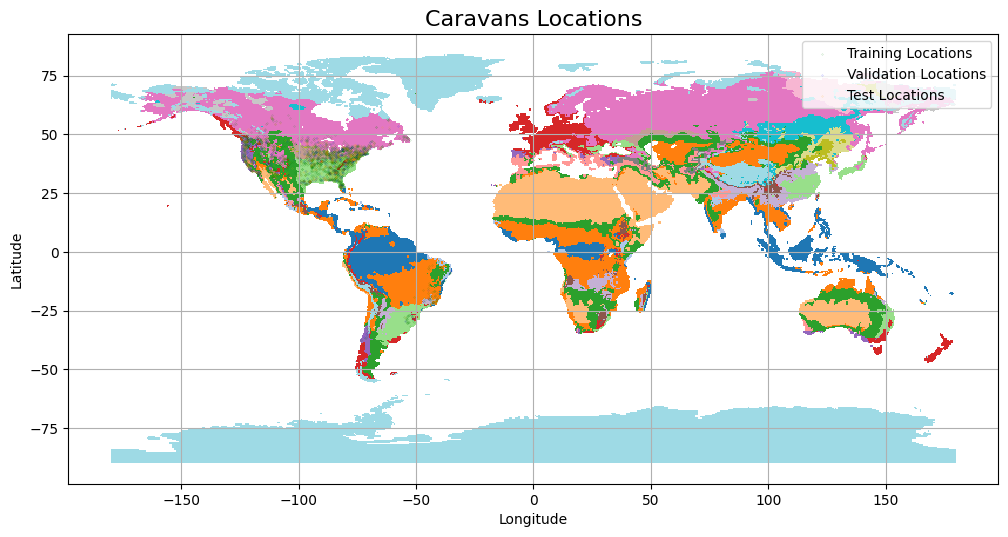

In [12]:
shapefile_path = "/home/mokr/GLOFAS_ML_Flood_Modelling/data/ne_110m_admin_0_countries/raw/ne_110m_admin_0_countries.shp"
Koppen_Geiger_Path = '/home/mokr/Loss_Functions_Paper/Kopen_Geiger/c1976_2000.shp'

# Load the shapefile into a GeoDataFrame
world = gpd.read_file(shapefile_path)
KG = gpd.read_file(Koppen_Geiger_Path)
KG_dissolved = KG.dissolve(by='GRIDCODE')
KG_dissolved = KG_dissolved.to_crs("EPSG:4326")
KG_dissolved['classification_area'] = KG_dissolved.area

KG = KG.to_crs("EPSG:4326")
KG['area'] = KG.area.sum()

# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))

KG_dissolved.plot(ax=ax, cmap='tab20')
# Overlay gauge locations
# filtered_catchments.plot(ax=ax, color='black', markersize=0.03, alpha = 0.5, label='Gauge Locations')
Train_catchments.plot(ax=ax, color='green', markersize=0.03, alpha = 0.5, label='Training Locations')
Validation_catchments.plot(ax=ax, color='blue', markersize=0.03, alpha = 0.5, label='Validation Locations')
Test_catchments.plot(ax=ax, color='orange', markersize=0.03, alpha = 0.5, label='Test Locations')
# Customize plot
plt.title("Caravans Locations", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
len(Train_catchments)


2445

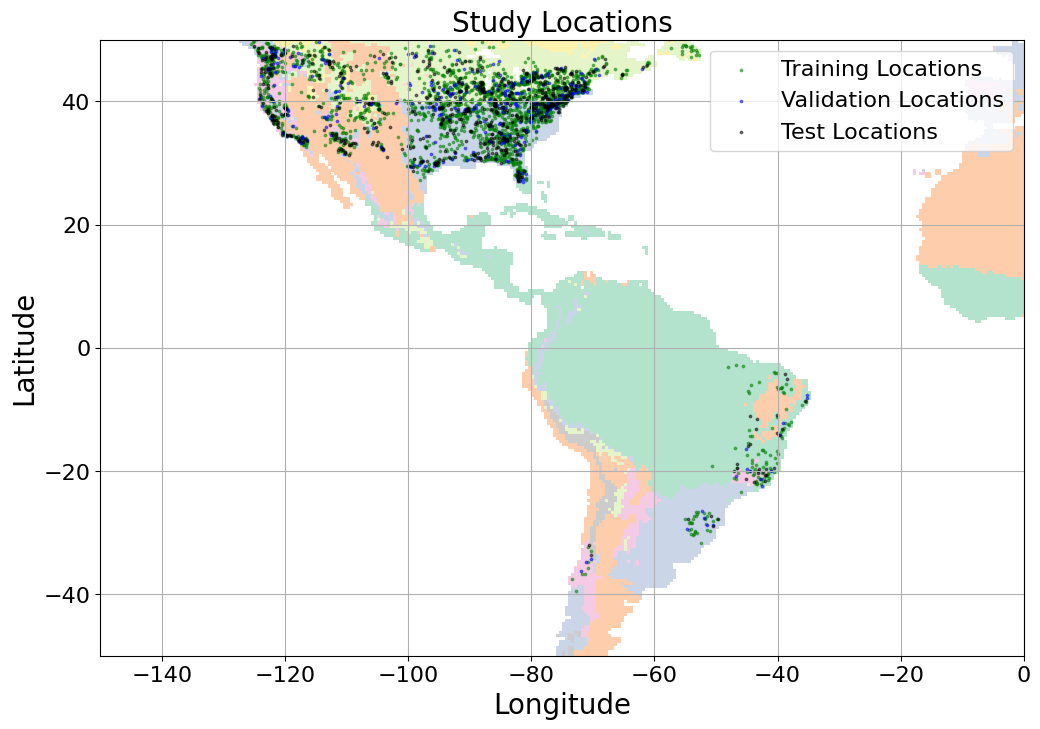

In [14]:
# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))
# Set plot extent
ax.set_xlim(-150, 0)
ax.set_ylim(-50, 50)
KG_dissolved.plot(ax=ax, cmap='Pastel2')

markersize = 3
alpha  = 0.5
# Overlay gauge locations
Train_catchments.plot(ax=ax, color='green', markersize=markersize, alpha = alpha, label='Training Locations')
Validation_catchments.plot(ax=ax, color='blue', markersize=markersize, alpha = alpha, label='Validation Locations')
Test_catchments.plot(ax=ax, color='black', markersize= markersize, alpha = alpha, label='Test Locations')
# Customize plot
plt.title("Study Locations", fontsize=20)
plt.xlabel("Longitude", fontsize = 20)
plt.ylabel("Latitude", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

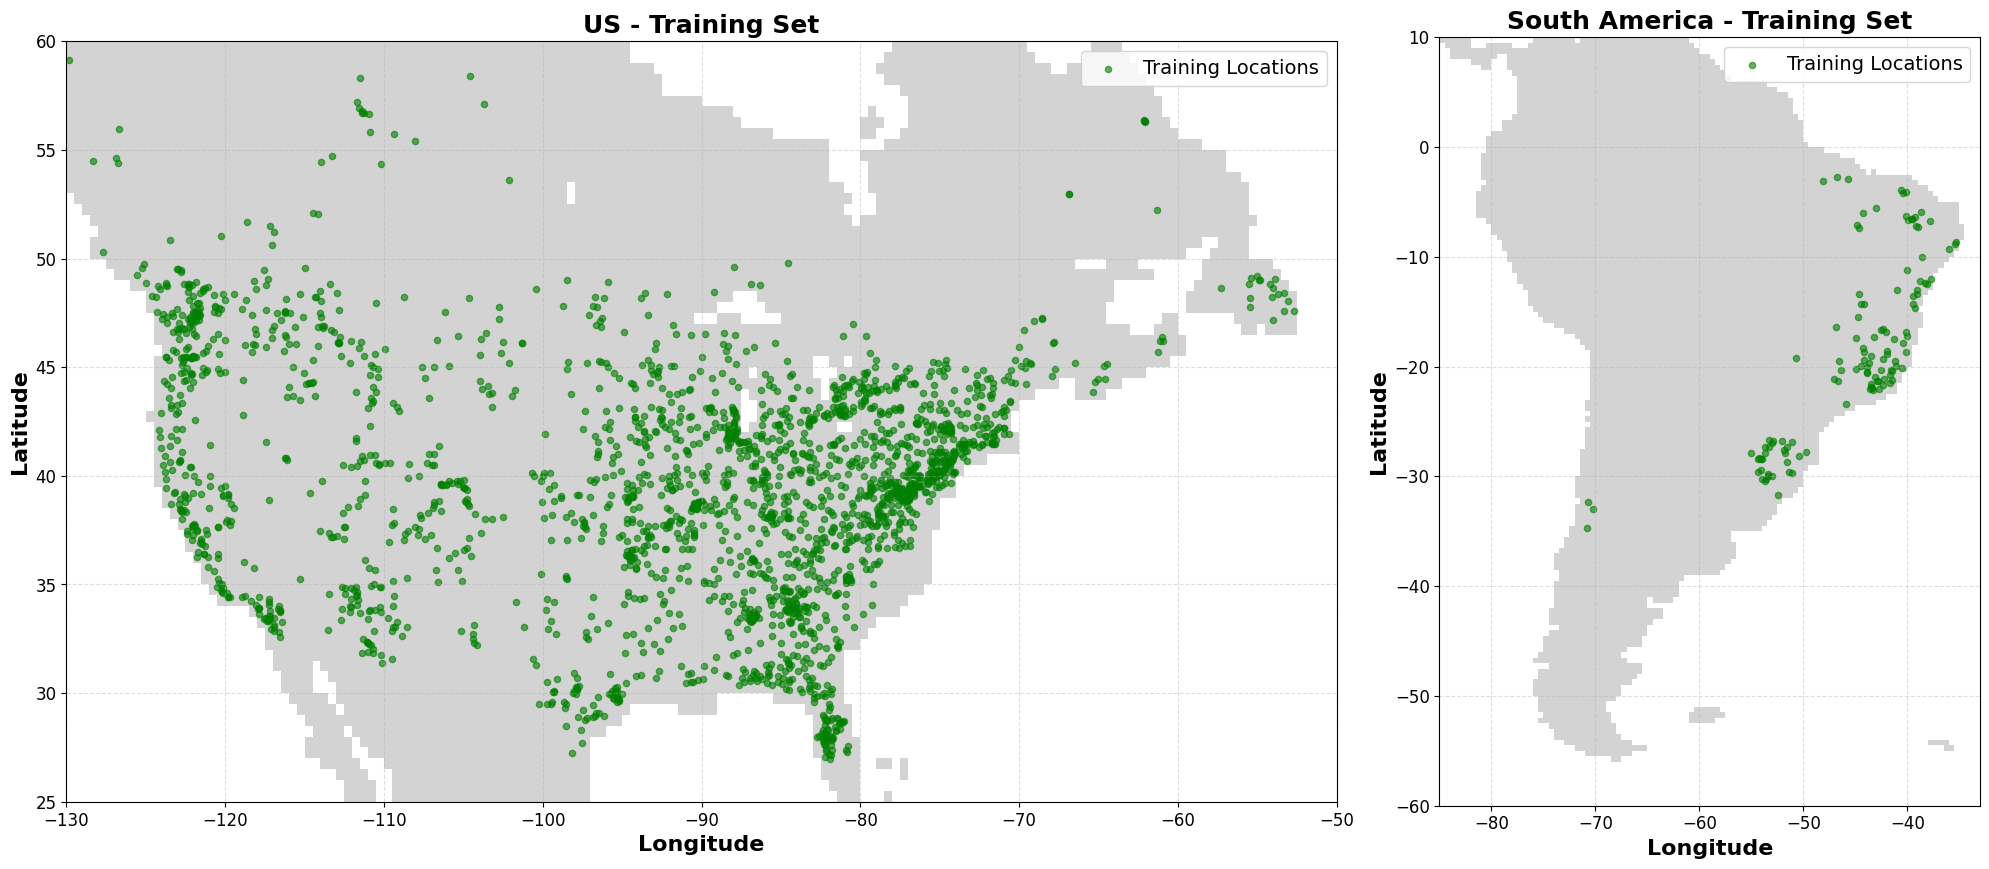

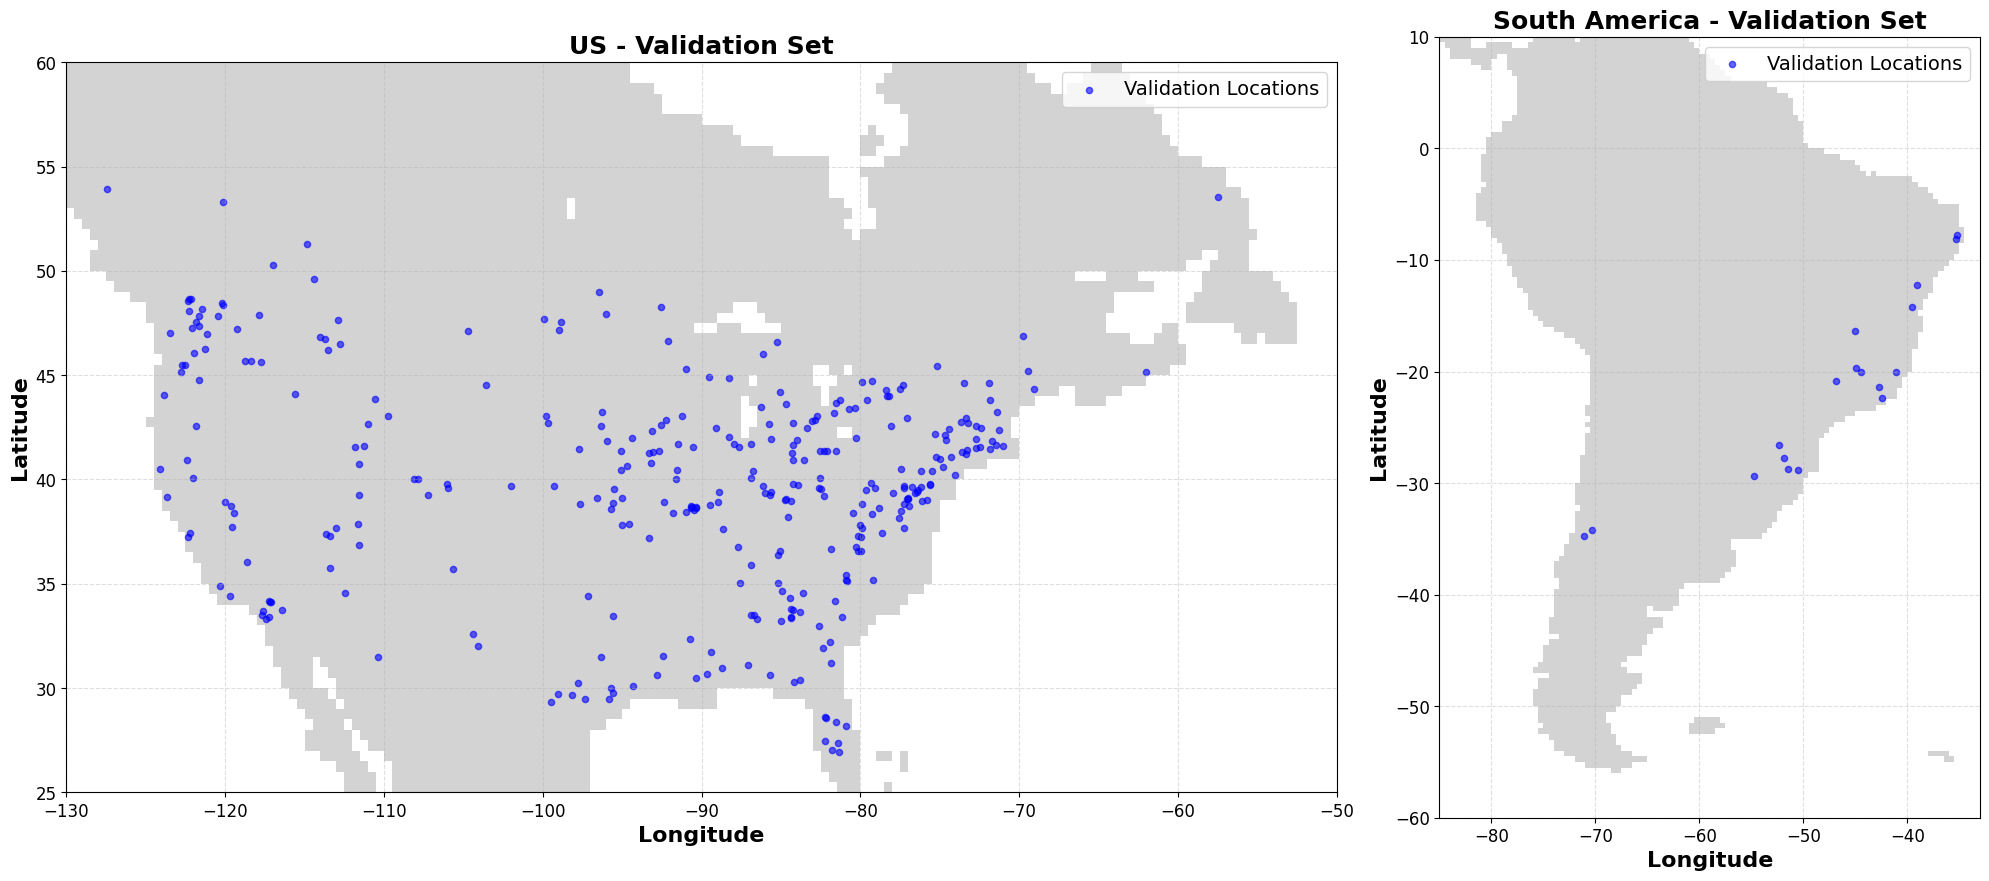

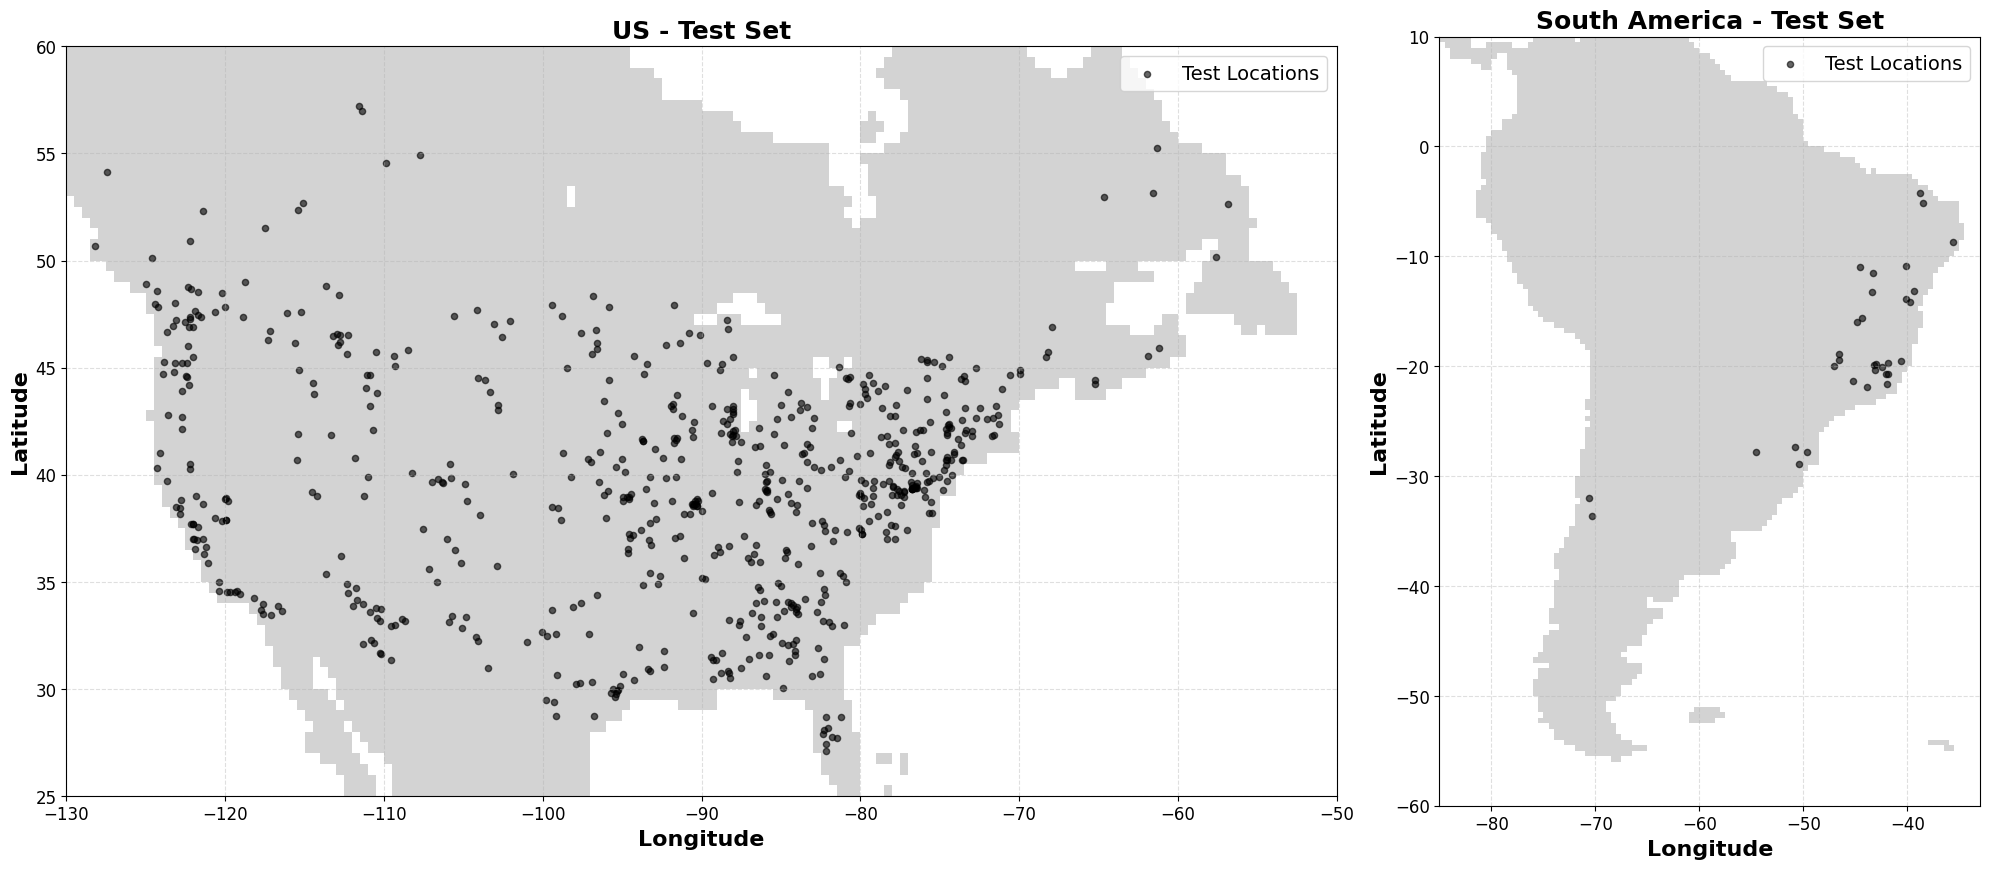

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# --- Color map setup ---
bounds = [0, 0.05, 0.2, 0.5, 1.0, 20]
base_cmap = plt.get_cmap('plasma')
colors = base_cmap(np.linspace(0, 1, 6))
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# --- General settings ---
Title_Size = 18
Label_Size = 16
Tick_Size = 12
Marker_Size = 20
Alpha = 0.6

# --- Coordinate filters for subregions ---
def subset_region(gdf, region):
    if region == "US":
        return gdf[(gdf.geometry.x >= -130) & (gdf.geometry.x <= -50) &
                   (gdf.geometry.y >= 25) & (gdf.geometry.y <= 60)]
    elif region == "Brazil":
        return gdf[(gdf.geometry.x >= -75) & (gdf.geometry.x <= -35) &
                   (gdf.geometry.y >= -35) & (gdf.geometry.y <= 10)]
    else:
        raise ValueError("Region must be 'US' or 'South America'")

# --- Function to make each two-panel figure ---
def plot_region_pair(train_gdf, valid_gdf, test_gdf, world, dataset_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.35, 1]}, figsize=(20, 10))

    # Left = US, Right = Brazil
    for ax, region, title in zip(
        [ax1, ax2],
        ["US", "Brazil"],
        [f"US - {dataset_label} Set", f"South America - {dataset_label} Set"]
    ):
        world.plot(ax=ax, color='lightgray', edgecolor=None)
        # KG_dissolved.plot(ax=ax, cmap='Pastel1')

        # Subset data
        if dataset_label == "Training":
            data = subset_region(train_gdf, region)
            color, label = 'green', 'Training Locations'
        elif dataset_label == "Validation":
            data = subset_region(valid_gdf, region)
            color, label = 'blue', 'Validation Locations'
        else:
            data = subset_region(test_gdf, region)
            color, label = 'black', 'Test Locations'

        # Plot points
        data.plot(ax=ax, color=color, markersize=Marker_Size, alpha=Alpha, label=label)

        # Region-specific limits
        if region == "US":
            ax.set_xlim([-130, -50])
            ax.set_ylim([25, 60])
        else:
            ax.set_xlim([-85, -33])
            ax.set_ylim([-60, 10])

        # Titles and labels
        ax.set_title(title, fontsize=Title_Size, fontweight='bold')
        ax.set_xlabel("Longitude", fontsize=Label_Size, fontweight='bold')
        ax.set_ylabel("Latitude", fontsize=Label_Size, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=Tick_Size)
        ax.legend(fontsize=14, loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()

# --- Call function for all three datasets ---
plot_region_pair(Train_catchments, Validation_catchments, Test_catchments, KG_dissolved, "Training")
plot_region_pair(Train_catchments, Validation_catchments, Test_catchments, KG_dissolved, "Validation")
plot_region_pair(Train_catchments, Validation_catchments, Test_catchments, KG_dissolved, "Test")


In [16]:
699/3494

0.20005724098454494

In [17]:
kg_main_groups = {
    'A': [11, 12, 13, 14],  # Tropical
    'B': [21, 22, 26, 27],  # Arid
    'C': [31, 32, 33, 34, 35, 36, 37, 38, 39],  # Temperate
    'D': [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],  # Cold
    'E': [61, 62]  # Polar
}

# --- Define standard Köppen–Geiger main group colours ---
kg_colors_main = {
    'A': '#66CC66',  # Light green – Tropical
    'B': '#FFE680',  # Soft yellow – Arid
    'C': '#66B2FF',  # Light blue – Temperate
    'D': '#CC99FF',  # Soft purple – Cold
    'E': '#E0E0E0',  # Light gray – Polar
}

kg_colors_main = {
    'A': '#8CD98C',  # Medium-light green – Tropical
    'B': '#FFF0A6',  # Medium-soft yellow – Arid
    'C': '#99CCFF',  # Medium-light blue – Temperate
    'D': '#D9B8FF',  # Medium-soft purple – Cold
    'E': '#E8E8E8',  # Medium-light gray – Polar
}
# --- Map GRIDCODE to main group ---
def map_to_main_group(code):
    for group, codes in kg_main_groups.items():
        if code in codes:
            return group
    return None

KG_dissolved["MainGroup"] = KG_dissolved.index.map(map_to_main_group)
kg_main_groups = {
    'A': [11, 12, 13, 14],  # Tropical
    'B': [21, 22, 26, 27],  # Arid
    'C': [31, 32, 33, 34, 35, 36, 37, 38, 39],  # Temperate
    'D': [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],  # Cold
    'E': [61, 62]  # Polar
}

# --- Define standard Köppen–Geiger main group colours ---


# --- Map GRIDCODE to main group ---
def map_to_main_group(code):
    for group, codes in kg_main_groups.items():
        if code in codes:
            return group
    return None

KG_dissolved["MainGroup"] = KG_dissolved.index.map(map_to_main_group)
KG_dissolved["Main_Colour"] = KG_dissolved["MainGroup"].map(kg_colors_main)


In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# ================================
# --- KÖPPEN–GEIGER COLORS ---
# ================================
kg_colors = {
    11: "#003EFF",  # Af
    12: "#00BFFF",  # Am
    13: "#66FFFF",  # As
    14: "#99FFFF",  # Aw
    21: "#FFFF00",  # BWk
    22: "#FFD300",  # BWh
    26: "#FFA500",  # BSk
    27: "#FF8C00",  # BSh
    31: "#00FF00",  # Cfa
    32: "#00B050",  # Cfb
    33: "#009E73",  # Cfc
    34: "#FF0000",  # Csa
    35: "#FF66B2",  # Csb
    36: "#FFB6C1",  # Csc
    37: "#CC0000",  # Cwa
    38: "#FF9999",  # Cwb
    39: "#FFCCCC",  # Cwc
    41: "#800080",  # Dfa
    42: "#9966CC",  # Dfb
    43: "#CC99FF",  # Dfc
    44: "#E6CCFF",  # Dfd
    45: "#A52A2A",  # Dsa
    46: "#CD5C5C",  # Dsb
    47: "#F08080",  # Dsc
    48: "#F5A9A9",  # Dsd
    49: "#8B0000",  # Dwa
    50: "#B22222",  # Dwb
    51: "#CD3333",  # Dwc
    52: "#E9967A",  # Dwd
    61: "#FFFFFF",  # EF
    62: "#B0E0E6"   # ET
}
kg_labels = {
    11: "Af", 12: "Am", 13: "As", 14: "Aw",
    21: "BWk", 22: "BWh", 26: "BSk", 27: "BSh",
    31: "Cfa", 32: "Cfb", 33: "Cfc", 34: "Csa", 35: "Csb", 36: "Csc",
    37: "Cwa", 38: "Cwb", 39: "Cwc",
    41: "Dfa", 42: "Dfb", 43: "Dfc", 44: "Dfd",
    45: "Dsa", 46: "Dsb", 47: "Dsc", 48: "Dsd",
    49: "Dwa", 50: "Dwb", 51: "Dwc", 52: "Dwd",
    61: "EF", 62: "ET"
}

kg_full_names = {
    'A': "Tropical",
    'B': "Arid",
    'C': "Temperate",
    'D': "Cold",
    'E': "Polar"
}

kg_cmap = mcolors.ListedColormap(list(kg_colors.values()))
kg_norm = mcolors.BoundaryNorm(list(kg_colors.keys()) + [63], kg_cmap.N)

KG_dissolved['color'] = KG_dissolved.index.map(kg_colors)

present_codes = KG_dissolved.index.unique()
present_colors = {code: kg_colors[code] for code in present_codes if code in kg_colors}

In [19]:

# ===================================
# --- REGION SUBSETTING FUNCTION ---
# ===================================
def subset_region(gdf, region):
    if region == "US":
        return gdf[(gdf.geometry.x >= -130) & (gdf.geometry.x <= -50) &
                   (gdf.geometry.y >= 25) & (gdf.geometry.y <= 60)]
    elif region == "Brazil":
        return gdf[(gdf.geometry.x >= -75) & (gdf.geometry.x <= -35) &
                   (gdf.geometry.y >= -35) & (gdf.geometry.y <= 10)]
    else:
        raise ValueError("Region must be 'US' or 'Brazil'")


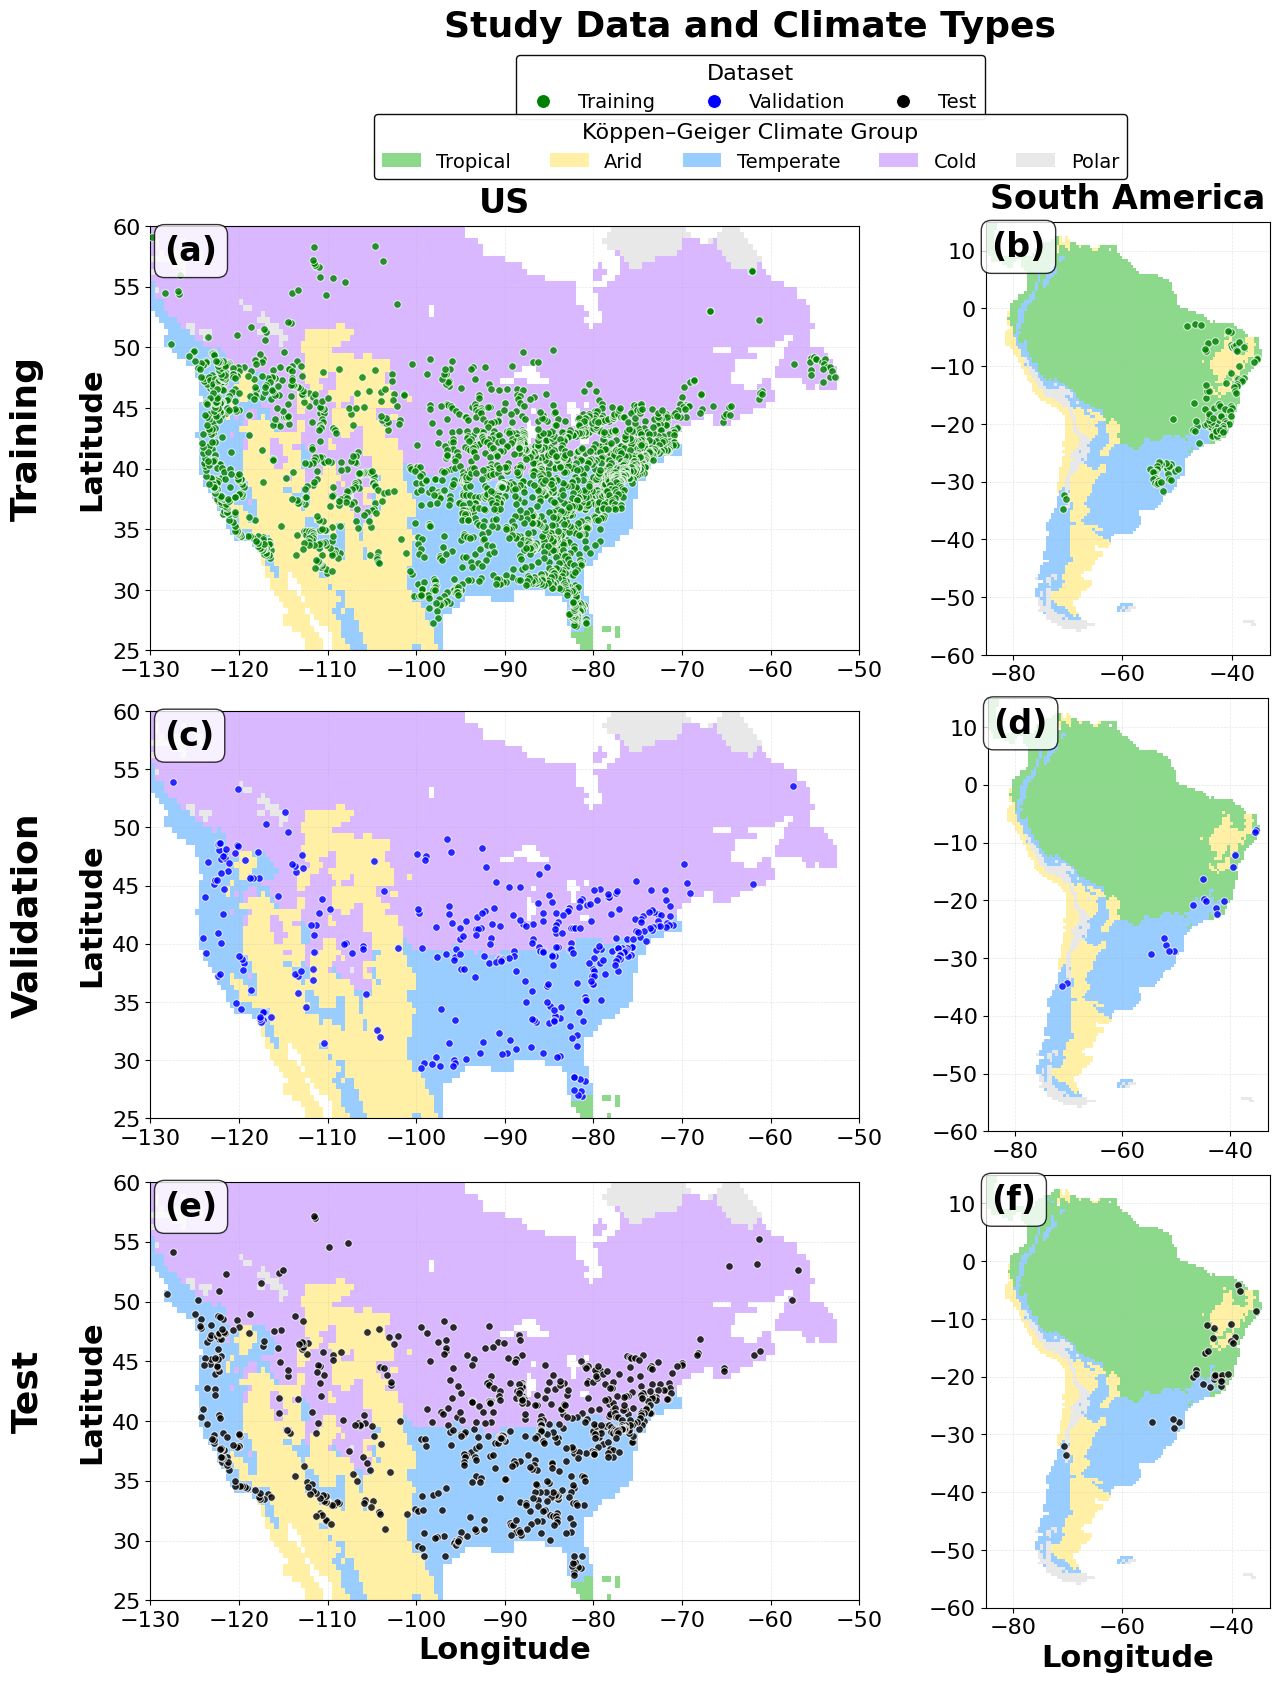

In [20]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# ===================================
# --- REGION SUBSETTING FUNCTION ---
# ===================================
def subset_region(gdf, region):
    if region == "US":
        return gdf[(gdf.geometry.x >= -130) & (gdf.geometry.x <= -50) &
                   (gdf.geometry.y >= 25) & (gdf.geometry.y <= 60)]
    elif region == "Brazil":
        return gdf[(gdf.geometry.x >= -75) & (gdf.geometry.x <= -35) &
                   (gdf.geometry.y >= -35) & (gdf.geometry.y <= 10)]
    else:
        raise ValueError("Region must be 'US' or 'Brazil'")

# ===================================
# --- PLOTTING FUNCTION ---
# ===================================
def plot_all_datasets(train_gdf, valid_gdf, test_gdf, KG_dissolved):
    """
    Creates a 3x2 grid of maps showing training, validation, and test locations
    for US (left) and Brazil (right) regions with shared legends.
    """
    Title_Size = 24
    Label_Size = 22
    Tick_Size = 16
    Marker_Size = 30
    Alpha = 0.8
    
    # Create figure with 3 rows, 2 columns
    fig = plt.figure(figsize=(16, 18))
    gs = fig.add_gridspec(3, 2, hspace=0.1, wspace=0.01, 
                          width_ratios=[1.35, 1])
    
    # Dataset configurations
    datasets = [
        (train_gdf, 'Training', 'green', '(a)', '(b)'),
        (valid_gdf, 'Validation', 'blue', '(c)', '(d)'),
        (test_gdf, 'Test', 'black', '(e)', '(f)')
    ]
    
    regions = [
        ('US', [-130, -50], [25, 60]),
        ('Brazil', [-85, -33], [-60, 15])
    ]
    
    # Create all subplots
    for row, (gdf, dataset_label, color, us_panel, br_panel) in enumerate(datasets):
        for col, (region, xlim, ylim) in enumerate(regions):
            ax = fig.add_subplot(gs[row, col])
            
            # Plot Köppen–Geiger background
            KG_dissolved.plot(ax=ax, color=KG_dissolved['Main_Colour'], 
                            edgecolor='none', linewidth=0)
            
            # Subset and plot data points
            data = subset_region(gdf, region)
            data.plot(ax=ax, facecolor=color, edgecolor='white', 
                     markersize=Marker_Size, linewidth=0.7, 
                     alpha=Alpha, zorder=3)

            # Add dataset labels on the left side
            if col == 0:
                ax.text(-0.15, 0.5, dataset_label, transform=ax.transAxes,
                       fontsize=Title_Size+2, fontweight='bold', 
                       va='center', ha='right', rotation=90)
            
            # Set region bounds
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            
            # Panel labels
            panel_label = us_panel if region == 'US' else br_panel
            ax.text(0.02, 0.98, panel_label, transform=ax.transAxes,
                   fontsize=Title_Size, fontweight='bold', va='top', ha='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Titles (only on top row)
            if row == 0:
                if region == 'Brazil':
                    region = 'South America'
                
                title = f"{region}"
                ax.set_title(title, fontsize=Title_Size, fontweight='bold', pad=10)
            
            # Labels
            if row == 2:  # Bottom row only
                ax.set_xlabel("Longitude", fontsize=Label_Size, fontweight='bold')
            else:
                ax.set_xlabel("")
                
            if col == 0:  # Left column only
                ax.set_ylabel("Latitude", fontsize=Label_Size, fontweight='bold')
            else:
                ax.set_ylabel("")
                # ax.set_yticklabels([])
            
            # Tick styling
            ax.tick_params(axis='both', which='major', labelsize=Tick_Size)
            ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)

    fig.suptitle('Study Data and Climate Types', fontsize=26, fontweight='bold', y=0.998)
    # ===================================
    # --- CREATE SHARED LEGENDS ---
    # ===================================
    
    # Dataset legend (points)
    point_handles = [
        Line2D([0], [0], marker='o', color='w', label='Training',
               markerfacecolor='green', markersize=10, 
               markeredgecolor='white', markeredgewidth=0.7),
        Line2D([0], [0], marker='o', color='w', label='Validation',
               markerfacecolor='blue', markersize=10, 
               markeredgecolor='white', markeredgewidth=0.7),
        Line2D([0], [0], marker='o', color='w', label='Test',
               markerfacecolor='black', markersize=10, 
               markeredgecolor='white', markeredgewidth=0.7)
    ]
    
    # Climate legend (Köppen-Geiger groups)
    present_groups = KG_dissolved["MainGroup"].dropna().unique()
    kg_handles = [Patch(facecolor=kg_colors_main[g], edgecolor='none',
                       label=kg_full_names[g]) 
                 for g in sorted(present_groups)]
    
    # Add legends outside the plot area
    leg1 = fig.legend(handles=point_handles, 
                     title="Dataset", 
                     loc='upper center',
                     bbox_to_anchor=(0.5, 0.978),
                     ncol=3, 
                     fontsize=14,
                     title_fontsize=16,
                     frameon=True,
                     framealpha=0.95,
                     edgecolor='black')
    
    leg2 = fig.legend(handles=kg_handles,
                     title="Köppen–Geiger Climate Group",
                     loc='upper center',
                     bbox_to_anchor=(0.5, 0.945),
                     ncol=len(kg_handles),
                     fontsize=14,
                     title_fontsize=16,
                     frameon=True,
                     framealpha=0.95,
                     edgecolor='black')
    
    plt.show()
    
    return fig

# ===================================
# --- CALL FUNCTION ---
# ===================================
fig = plot_all_datasets(Train_catchments, Validation_catchments, 
                        Test_catchments, KG_dissolved)

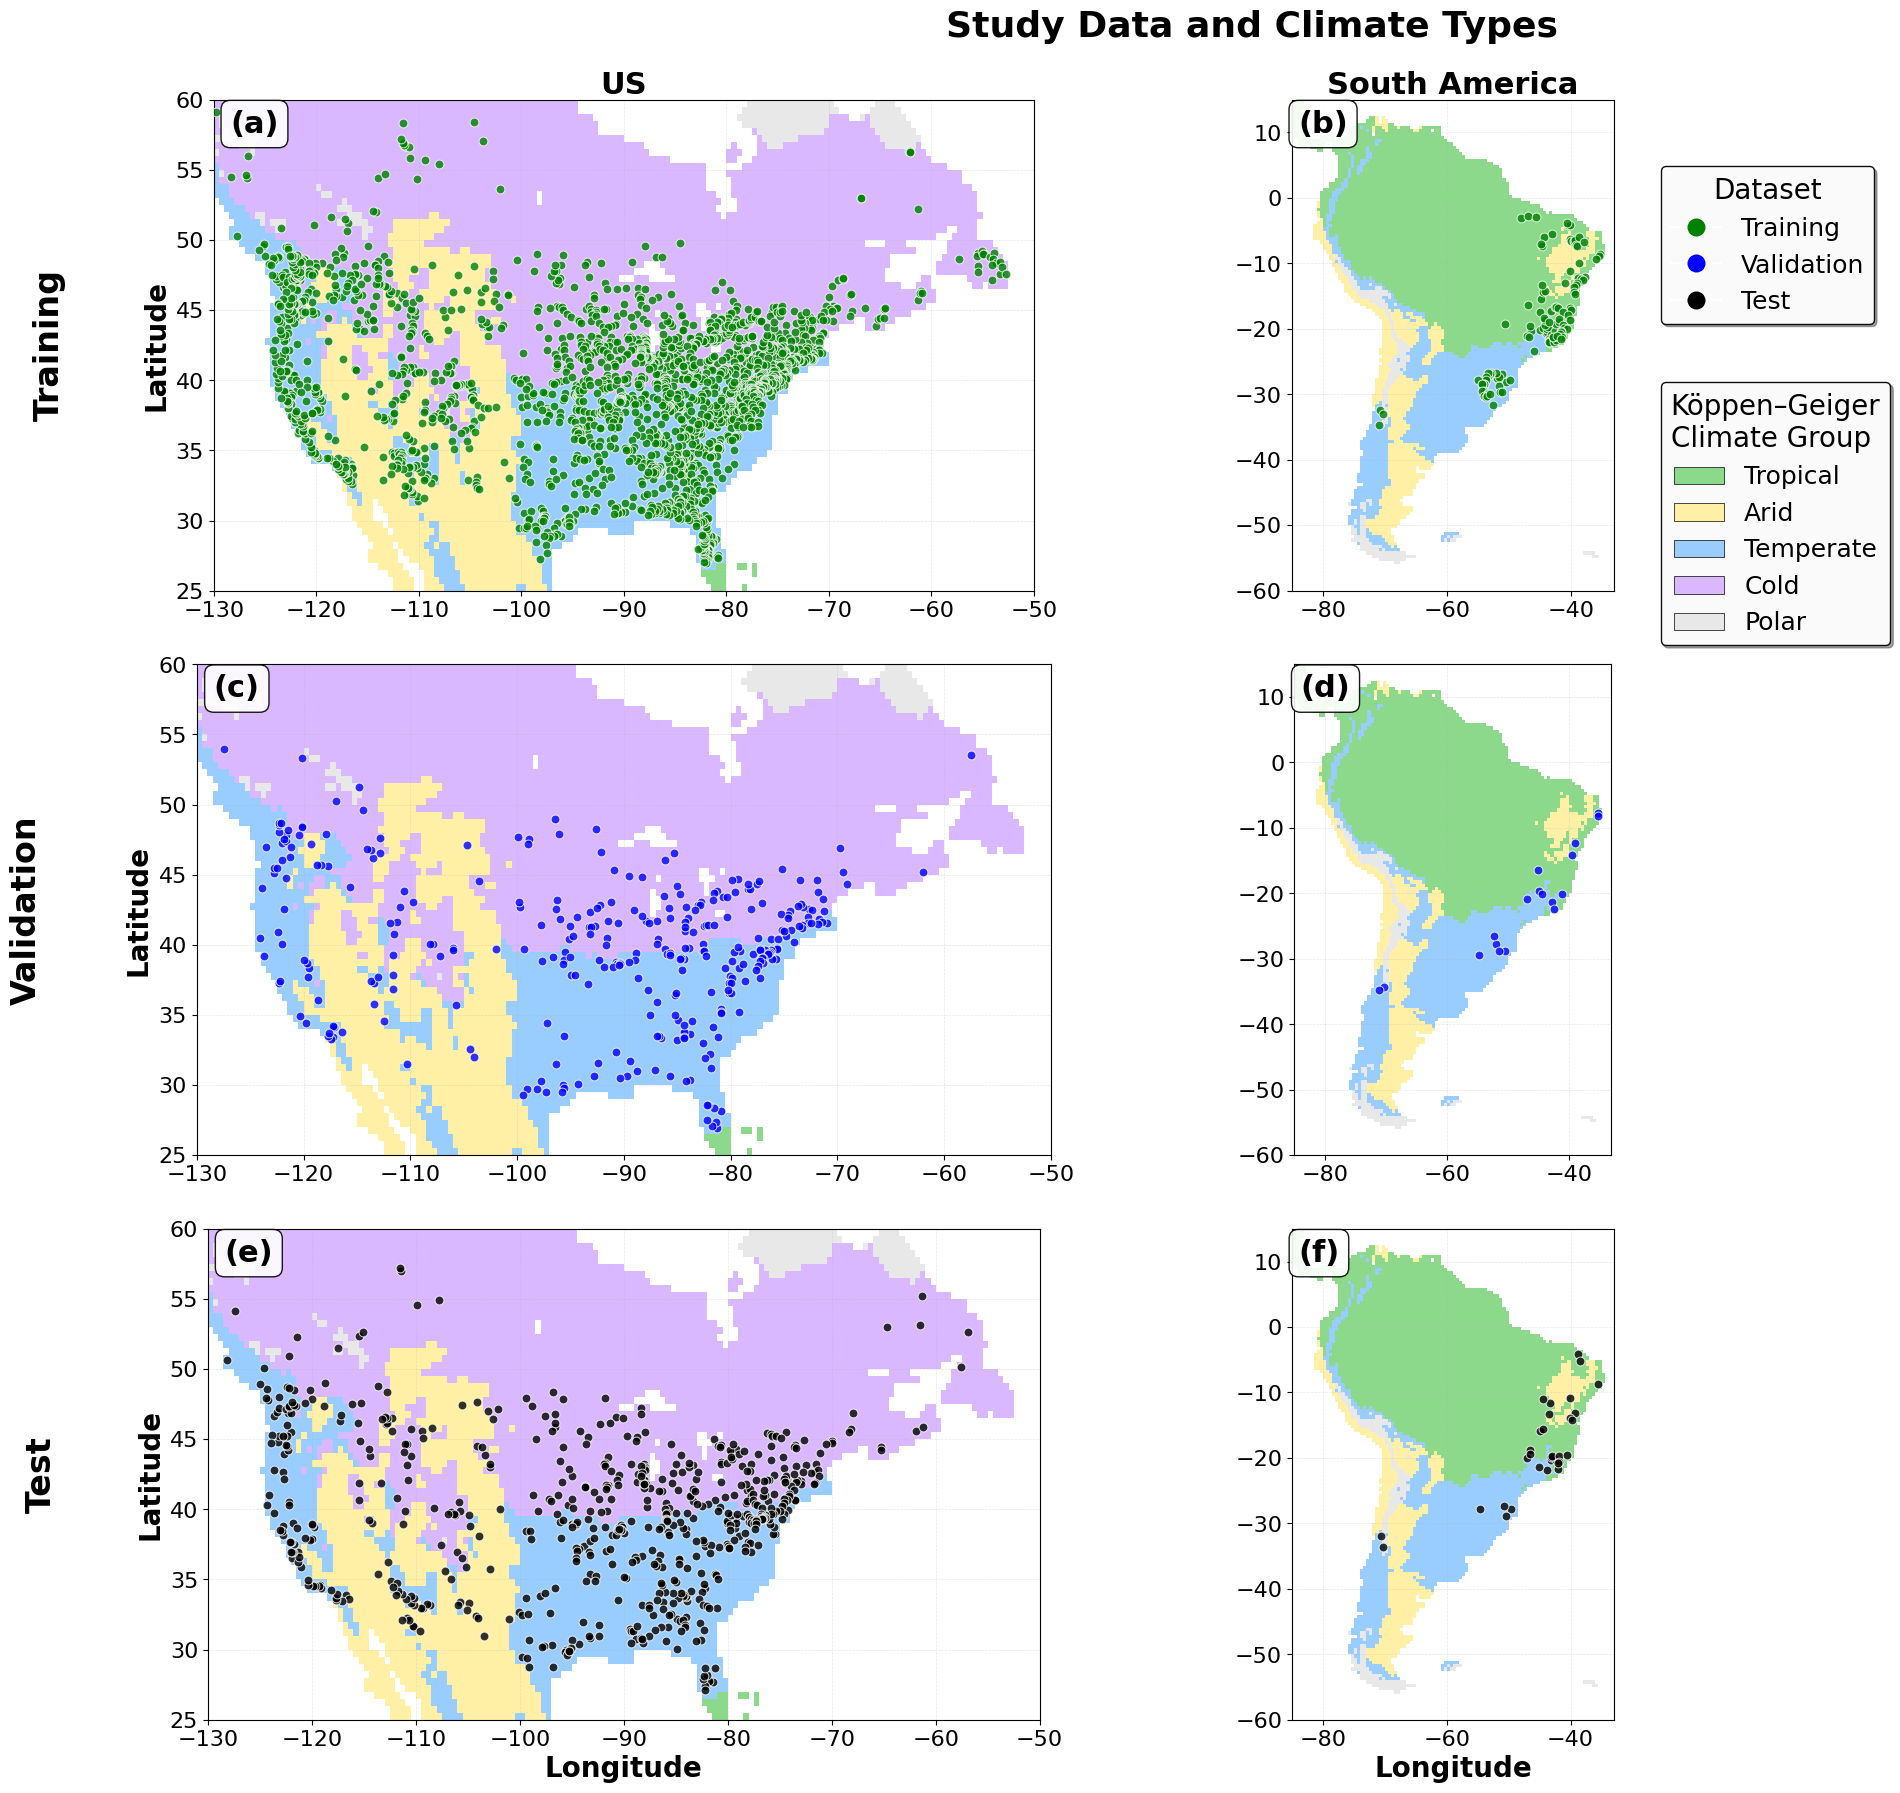

In [21]:
# ===================================
# --- REGION SUBSETTING FUNCTION ---
# ===================================
def subset_region(gdf, region):
    if region == "US":
        return gdf[(gdf.geometry.x >= -130) & (gdf.geometry.x <= -50) &
                   (gdf.geometry.y >= 25) & (gdf.geometry.y <= 60)]
    elif region == "Brazil":
        return gdf[(gdf.geometry.x >= -75) & (gdf.geometry.x <= -35) &
                   (gdf.geometry.y >= -35) & (gdf.geometry.y <= 10)]
    else:
        raise ValueError("Region must be 'US' or 'Brazil'")

# ===================================
# --- PLOTTING FUNCTION ---
# ===================================
def plot_all_datasets(train_gdf, valid_gdf, test_gdf, KG_dissolved):
    """
    Creates a 3x2 grid of maps showing training, validation, and test locations
    for US (left) and Brazil (right) regions with shared legends on the side.
    """
    Title_Size = 22
    Label_Size = 20
    Tick_Size = 16
    Marker_Size = 40
    Alpha = 0.8
    
    # Create figure with 3 rows, 2 columns + space for legend
    fig = plt.figure(figsize=(22, 18))
    gs = fig.add_gridspec(3, 2, hspace=0.15, wspace=0.01, 
                          left=0.0, right=0.75, top=0.95, bottom=0.05,
                          width_ratios=[1.35, 1])
    
    # Dataset configurations
    datasets = [
        (train_gdf, 'Training', 'green', '(a)', '(b)'),
        (valid_gdf, 'Validation', 'blue', '(c)', '(d)'),
        (test_gdf, 'Test', 'black', '(e)', '(f)')
    ]
    
    regions = [
        ('US', [-130, -50], [25, 60]),
        ('Brazil', [-85, -33], [-60, 15])
    ]
    
    # Create all subplots
    for row, (gdf, dataset_label, color, us_panel, br_panel) in enumerate(datasets):
        for col, (region, xlim, ylim) in enumerate(regions):
            ax = fig.add_subplot(gs[row, col])
            
            # Plot Köppen–Geiger background
            KG_dissolved.plot(ax=ax, color=KG_dissolved['Main_Colour'], 
                            edgecolor='none', linewidth=0)
            
            # Subset and plot data points
            data = subset_region(gdf, region)
            data.plot(ax=ax, facecolor=color, edgecolor='white', 
                     markersize=Marker_Size, linewidth=0.7, 
                     alpha=Alpha, zorder=3)

            # Add dataset labels on the left side
            if col == 0:
                ax.text(-0.18, 0.5, dataset_label, transform=ax.transAxes,
                       fontsize=Title_Size+2, fontweight='bold', 
                       va='center', ha='right', rotation=90)
            
            # Set region bounds
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            
            # Panel labels
            panel_label = us_panel if region == 'US' else br_panel
            ax.text(0.02, 0.98, panel_label, transform=ax.transAxes,
                   fontsize=Title_Size, fontweight='bold', va='top', ha='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
            
            # Titles (only on top row)
            if row == 0:
                if region == 'Brazil':
                    region = 'South America'
                
                title = f"{region}"
                ax.set_title(title, fontsize=Title_Size, fontweight='bold', pad=1)
            
            # Labels
            if row == 2:  # Bottom row only
                ax.set_xlabel("Longitude", fontsize=Label_Size, fontweight='bold')
            else:
                ax.set_xlabel("")
                
            if col == 0:  # Left column only
                ax.set_ylabel("Latitude", fontsize=Label_Size, fontweight='bold')
            else:
                ax.set_ylabel("")
            
            # Tick styling
            ax.tick_params(axis='both', which='major', labelsize=Tick_Size)
            ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)

    fig.suptitle('Study Data and Climate Types', fontsize=26, fontweight='bold', y=1)
    
    # ===================================
    # --- CREATE SHARED LEGENDS ON SIDE ---
    # ===================================
    
    # Dataset legend (points) - positioned on right side, top
    point_handles = [
        Line2D([0], [0], marker='o', color='w', label='Training',
               markerfacecolor='green', markersize=14, 
               markeredgecolor='white', markeredgewidth=1.0),
        Line2D([0], [0], marker='o', color='w', label='Validation',
               markerfacecolor='blue', markersize=14, 
               markeredgecolor='white', markeredgewidth=1.0),
        Line2D([0], [0], marker='o', color='w', label='Test',
               markerfacecolor='black', markersize=14, 
               markeredgecolor='white', markeredgewidth=1.0)
    ]
    
    # Climate legend (Köppen-Geiger groups)
    present_groups = KG_dissolved["MainGroup"].dropna().unique()
    kg_handles = [Patch(facecolor=kg_colors_main[g], edgecolor='black', linewidth=0.5,
                       label=kg_full_names[g]) 
                 for g in sorted(present_groups)]
    
    # Add legends on the right side
    leg1 = fig.legend(handles=point_handles, 
                     title="Dataset", 
                     loc='upper left',
                     bbox_to_anchor=(0.68, 0.92),
                     fontsize=18,
                     title_fontsize=20,
                     frameon=True,
                     framealpha=0.95,
                     edgecolor='black',
                     fancybox=True,
                     shadow=True)
    
    leg2 = fig.legend(handles=kg_handles,
                     title="Köppen–Geiger\nClimate Group",
                     loc='upper left',
                     bbox_to_anchor=(0.68, 0.8),
                     fontsize=18,
                     title_fontsize=20,
                     frameon=True,
                     framealpha=0.95,
                     edgecolor='black',
                     fancybox=True,
                     shadow=True)
    
    plt.savefig('study_data_climate.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ===================================
# --- CALL FUNCTION ---
# ===================================
fig = plot_all_datasets(Train_catchments, Validation_catchments, 
                        Test_catchments, KG_dissolved)

In [22]:
Loss_Functions_Paper/Catchment_Averaging/ML_basin_splits.pkl

NameError: name 'Loss_Functions_Paper' is not defined

In [ ]:
# Convert lat-lon pairs to GeoDataFrame

# Spatial join to assign a KG class
joined = gpd.sjoin(filtered_catchments, KG_dissolved, how="left", predicate="within")
joined_clean = joined.dropna(subset=['GRIDCODE'])
# Caravans has 24 unique catchments, so 7 climate types are missing
joined_clean.nunique() 

# Plot range of areas for each KG class in the dataset
plt.figure(figsize=(10, 6))
for idx, KG_Type in enumerate(joined_clean['GRIDCODE'].unique()):
    # Get all points for this GRIDCODE
    KG_Type_Catchments = joined_clean[joined_clean['GRIDCODE'] == KG_Type]
   
    # Plot individual stations as points
    plt.scatter([KG_Type]*len(KG_Type_Catchments), KG_Type_Catchments['area'], s = 20, marker = 'o', alpha=0.5, label = KG_Type)

plt.yscale('log')
plt.ylim([1e-1,1e7])
plt.xlabel('Koppen-Geiger Classification Type')
plt.ylabel('Area $(km^{2})$')
plt.title('Caravans Catchment Distribution by Area and Climate Zone')
plt.show()

In [ ]:
# Iterate over each data_source
for data_source in set(Folder_Data_Sources):
    # Load the shapefile for the current data_source
    source_data = Geopandas_sources[data_source]
    
    # Filter rows in joined_clean where 'gauge_id' starts with {data_source}_
    rows_to_update = joined_clean[joined_clean['gauge_id'].str.startswith(f"{data_source}_")]
    
    # Ensure geometries are aligned between the two GeoDataFrames
    if not rows_to_update.empty:
        # Extract corresponding geometries from the source_data
        # Assuming 'gauge_id' exists in source_data to match joined_clean
        updated_geometries = rows_to_update['gauge_id'].map(
            source_data.set_index('gauge_id')['geometry']
        )
        
        # Update the geometry column in joined_clean
        joined_clean.loc[rows_to_update.index, 'geometry'] = updated_geometries

In [ ]:
KG_dissolved_present = KG_dissolved[KG_dissolved.index.isin(joined_clean['GRIDCODE'].unique())]
KG_dissolved_present['ideal_sample_fraction'] = KG_dissolved_present['classification_area']/np.sum(KG_dissolved_present['classification_area'])
KG_dissolved_present

In [ ]:
import warnings
# Initialize an empty DataFrame to store sampled catchments
sampled_catchments = pd.DataFrame()
total_samples = 100
for idx, KG_Type in enumerate(joined_clean['GRIDCODE'].unique()):
    # Get all points for this KG_Type
    KG_Type_Catchments = joined_clean[joined_clean['GRIDCODE'] == KG_Type]
    
    # Get the proportion of the world for this KG_Type
    proportion = KG_dissolved_present[KG_dissolved_present.index == KG_Type]['ideal_sample_fraction']
    
    # Calculate the number of samples, ensuring at least 1
    sample_size = max(1, int(np.round(proportion * total_samples).iloc[0]))

    # print('New KG Type')
    for _ in range(sample_size):
        # print(len(KG_Type_Catchments))
        if KG_Type_Catchments.empty:
            break  # Stop if there are no catchments left to sample
        
        # Randomly select one catchment
        sampled = KG_Type_Catchments.sample(n=1, random_state=42)
        
        # Append the sampled catchment to the results
        sampled_catchments = pd.concat([sampled_catchments, sampled], ignore_index=True)
        # print('sampled catchments', len(sampled_catchments))
        # Remove the sampled catchment and any overlapping catchments
        buffered_sampled = sampled.copy()
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.*")
            buffered_sampled['geometry'] = buffered_sampled.geometry.buffer(0.5)
        # Perform the spatial join using the buffered geometries
        overlapping = KG_Type_Catchments.sjoin(buffered_sampled, how='inner', predicate='intersects')
        KG_Type_Catchments = KG_Type_Catchments.drop(index=overlapping.index)
        
# Display the sampled catchments
# sampled_catchments

In [ ]:
# Plot range of areas for each KG class in the sample
plt.figure(figsize=(10, 6))
for idx, KG_Type in enumerate(sampled_catchments['GRIDCODE'].unique()):
    # Get all points for this GRIDCODE
    KG_Type_Catchments = sampled_catchments[sampled_catchments['GRIDCODE'] == KG_Type]
   
    # Plot individual stations as points
    plt.scatter([KG_Type]*len(KG_Type_Catchments), KG_Type_Catchments['area'], s = 20, marker = 'o', alpha=1, label = KG_Type)

plt.yscale('log')
plt.xlabel('Koppen-Geiger Classification Type')
plt.ylim([1e-1,1e7])
plt.ylabel('Area $(km^{2})$')
plt.title('Sample Catchment Distribution by Area and Climate Zone')
plt.show()


In [ ]:
# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))

KG_dissolved.plot(ax=ax, cmap='tab20')
# Overlay gauge locations
sampled_catchments.plot(ax=ax, color='black', markersize=3, alpha = 0.5, label='Gauge Locations')

# Customize plot
plt.title("Sampled Catchment Locations", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Calculate proportions for each dataset
proportions_joined_clean = joined_clean['GRIDCODE'].value_counts(normalize=True)
proportions_sampled_catchments = sampled_catchments['GRIDCODE'].value_counts(normalize=True)
proportions_ideal = KG_dissolved_present['ideal_sample_fraction']

# Align proportions to have the same set of GRIDCODEs across all pie charts
all_gridcodes = set(proportions_joined_clean.index) | set(proportions_sampled_catchments.index) | set(proportions_ideal.index)

proportions_joined_clean = proportions_joined_clean.reindex(all_gridcodes, fill_value=0)
proportions_sampled_catchments = proportions_sampled_catchments.reindex(all_gridcodes, fill_value=0)
proportions_ideal = proportions_ideal.reindex(all_gridcodes, fill_value=0)

# Create the pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

angle = 140
textprop = 5
distance= 1.2

# Pie chart for joined_clean
axes[0].pie(
    proportions_joined_clean, 
    labels=proportions_joined_clean.index.astype(int), 
    # autopct='%1.1f%%', 
    startangle=angle, 
    textprops={'fontsize': textprop},
    labeldistance = distance
)
axes[0].set_title('Proportions in Caravans')

# Pie chart for sampled_catchments
axes[1].pie(
    proportions_sampled_catchments, 
    labels=proportions_sampled_catchments.index.astype(int), 
    # autopct='%1.1f%%', 
    startangle=angle, 
    textprops={'fontsize': textprop},
    labeldistance = distance
)
axes[1].set_title('Proportions in Sampled Catchments')

# Pie chart for ideal_sample_fraction
axes[2].pie(
    proportions_ideal, 
    labels=proportions_ideal.index.astype(int), 
    # autopct='%1.1f%%', 
    startangle=angle, 
    textprops={'fontsize': textprop},
    labeldistance = distance
)
axes[2].set_title('Proportions in World')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


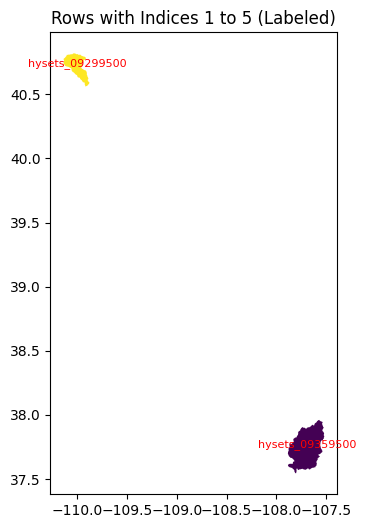

In [19]:
subset = sampled_catchments.iloc[41:43]

# Plot the subset
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(ax=ax, cmap='viridis')

# Add labels
for idx, row in subset.iterrows():
    # Assuming 'gauge_id' is the column you want to use for labels
    label = row['gauge_id']
    x, y = row.geometry.centroid.x, row.geometry.centroid.y  # Get centroid for labeling
    ax.text(x, y, label, fontsize=8, ha='center', color='red')  # Customize font size and color

plt.title("Rows with Indices 1 to 5 (Labeled)")
plt.show()


In [32]:
# Create a new GeoDataFrame with only the columns you want
subset_gdf = sampled_catchments[['gauge_id', 'geometry', 'GRIDCODE']]

# Save to shapefile
subset_gdf.to_file('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Sampled_Catchments/sampled_catchments.shp')

In [20]:
sampled_catchments

,gauge_id,gauge_name,country,gauge_lat,gauge_lon,area,geometry,GRIDCODE,ID,classification_area
0,camelsbr_32830000,alto turi,Brazil,-2.944200,-45.667200,3910.171047,"POLYGON ((-46.15833 -3.38333, -46.16847 -3.380...",12.0,1316.0,453.75
1,camelsbr_33480000,colinas,Brazil,-6.020800,-44.248600,15015.684896,"POLYGON ((-45.29167 -6.94583, -45.29379 -6.943...",14.0,1297.0,1452.75
2,camelsbr_35740000,barra nova,Brazil,-4.193333,-38.779722,221.743085,"POLYGON ((-38.95833 -4.25, -38.96462 -4.24796,...",14.0,1297.0,1452.75
3,camelsbr_36210000,sitio lapinha,Brazil,-7.222222,-39.143889,1281.278642,"POLYGON ((-39.26667 -7.4375, -39.28124 -7.433,...",14.0,1297.0,1452.75
4,camelsbr_41440005,represa jusante,Brazil,-19.371389,-44.152778,242.560111,"POLYGON ((-44.225 -19.55417, -44.23219 -19.552...",14.0,1297.0,1452.75
...,...,...,...,...,...,...,...,...,...,...
66,hysets_11089500,FULLERTON C BL FULLERTON DAM NR BREA CA,United States of America,33.895848,-117.886171,12.905643,"POLYGON ((-117.89319 33.89756, -117.89319 33.8...",34.0,493.0,272.75
67,hysets_09423350,CARUTHERS C NR IVANPAH CA,United States of America,35.244989,-115.298876,2.120520,"POLYGON ((-115.29717 35.2438, -115.29717 35.24...",21.0,481.0,504.25
68,hysets_10259200,DEEP C NR PALM DESERT CA,United States of America,33.631136,-116.392234,78.980417,"POLYGON ((-116.44767 33.59367, -116.44767 33.5...",22.0,1061.0,1881.25
69,hysets_12413125,"CANYON CREEK AB MOUTH AT WALLACE, ID",United States of America,47.472500,-115.914722,56.880521,"POLYGON ((-115.86562 47.52547, -115.86562 47.5...",46.0,426.0,52.25


In [38]:
ERA5_zarr_path = '/perm/mokr/Caravans_MultiMet/ERA5_LAND/timeseries.zarr'
ERA5_Land = xr.open_zarr(store=ERA5_zarr_path, chunks=None)
ERA5_Land.info

<bound method Dataset.info of <xarray.Dataset> Size: 37GB
Dimensions:                                             (basin: 22485,
                                                         date: 27333)
Coordinates:
  * basin                                               (basin) <U22 2MB 'cam...
  * date                                                (date) datetime64[ns] 219kB ...
Data variables: (12/15)
    era5land_dewpoint_temperature_2m                    (basin, date) float32 2GB ...
    era5land_potential_evaporation_DEPRECATED           (basin, date) float32 2GB ...
    era5land_potential_evaporation_FAO_PENMAN_MONTEITH  (basin, date) float32 2GB ...
    era5land_snow_depth_water_equivalent                (basin, date) float32 2GB ...
    era5land_surface_net_solar_radiation                (basin, date) float32 2GB ...
    era5land_surface_net_thermal_radiation              (basin, date) float32 2GB ...
    ...                                                  ...
    era5land_u_com

In [51]:
# Assuming sampled_catchments is a DataFrame/Series with gauge_id column
basin_list = sampled_catchments['gauge_id'].tolist()

# Extract data for all basins in the list
selected_basins = ERA5_Land.where(ERA5_Land['basin'].isin(basin_list), drop=True)

In [60]:
Hyset_example = selected_basins.where(selected_basins['basin'] == 'hysets_11027000', drop = True)


In [69]:
# Save as NetCDF file (most common format for xarray)
selected_basins.to_netcdf('Sampled_Catchments/ERA5_Sampled_Catchments.nc')
# selected_basins.to_zarr('Sampled_Catchments/ERA5_Sampled_Catchments.zarr')

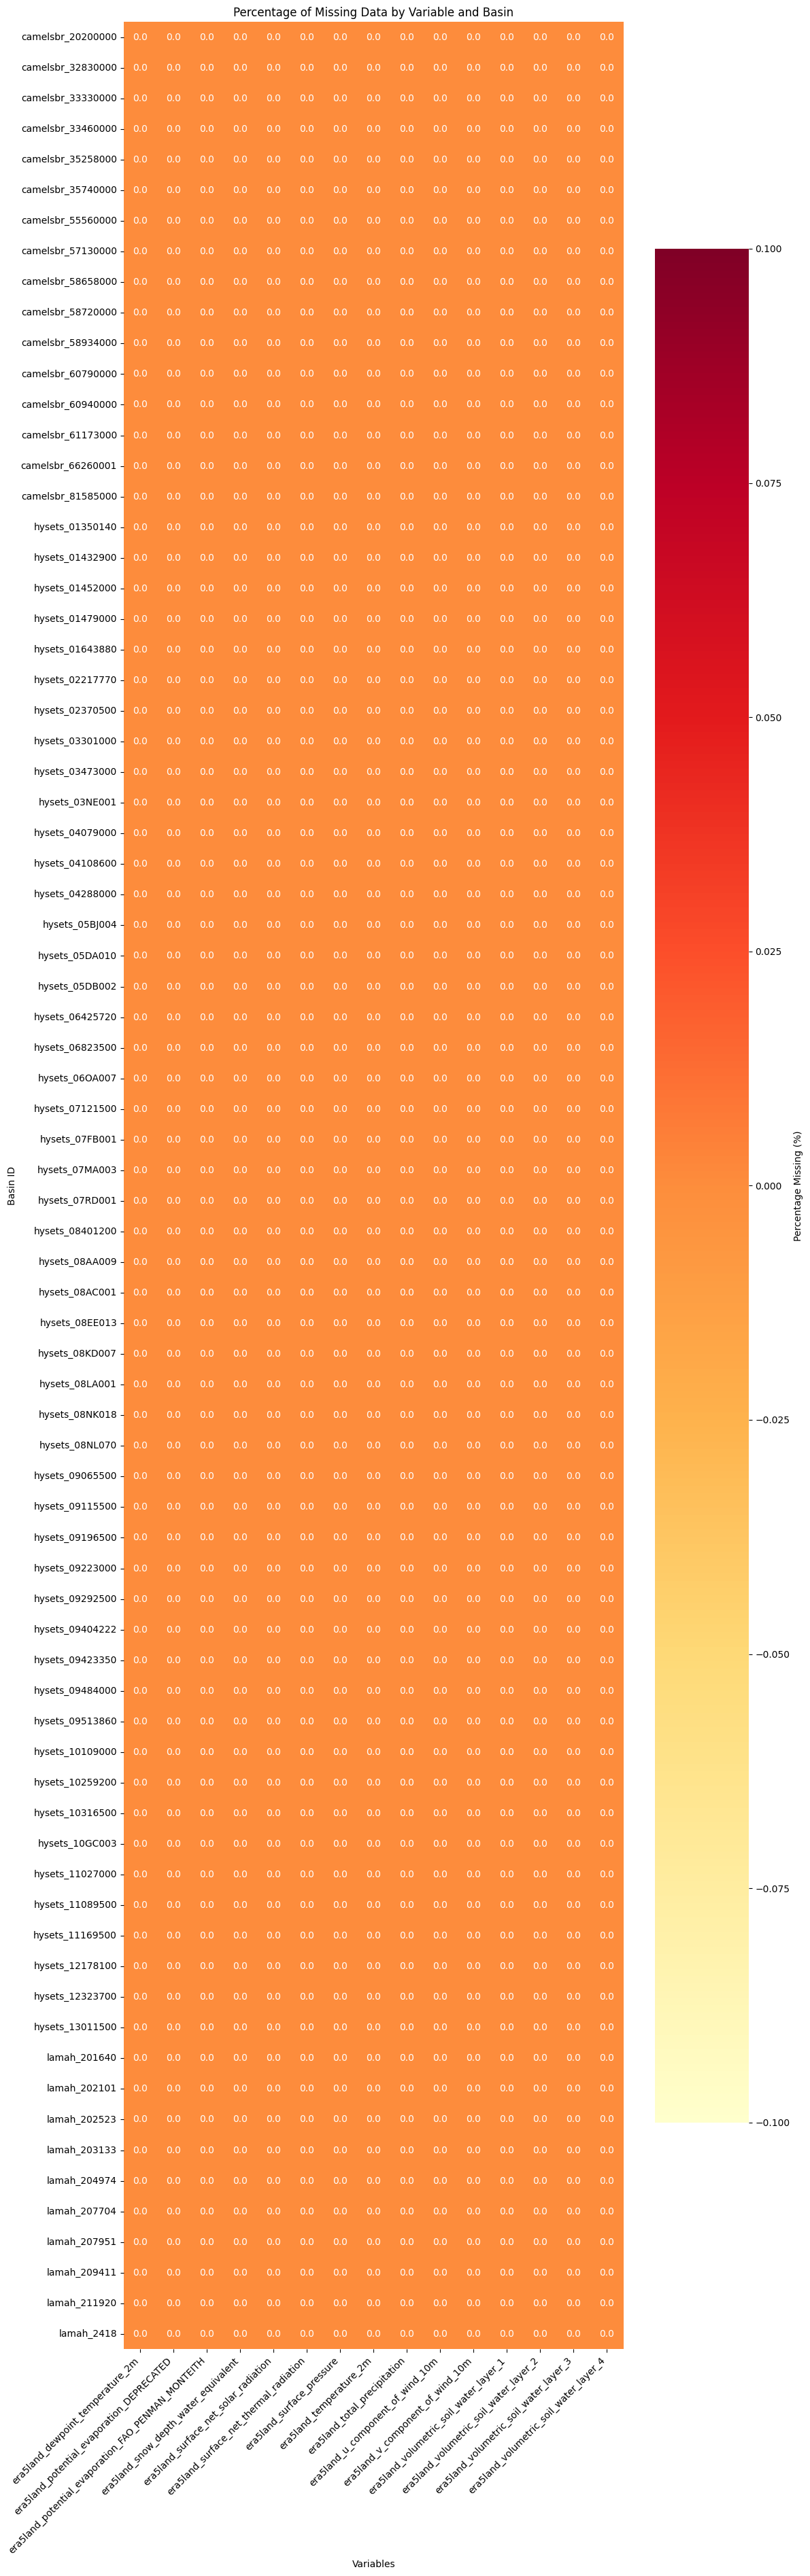


Summary of missing data:
       era5land_dewpoint_temperature_2m  \
count                              76.0   
mean                                0.0   
std                                 0.0   
min                                 0.0   
25%                                 0.0   
50%                                 0.0   
75%                                 0.0   
max                                 0.0   

       era5land_potential_evaporation_DEPRECATED  \
count                                       76.0   
mean                                         0.0   
std                                          0.0   
min                                          0.0   
25%                                          0.0   
50%                                          0.0   
75%                                          0.0   
max                                          0.0   

       era5land_potential_evaporation_FAO_PENMAN_MONTEITH  \
count                                               76.0

In [72]:
# No data is missing in ERA5 Land, just need to get the hindcasts now

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentage of missing values for each variable and basin
missing_data = {}

# Get list of all variables
variables = list(selected_basins.data_vars)

for var in variables:
    # Calculate percentage of missing values for each basin
    missing_pct = (selected_basins[var].isnull().sum(dim='date') / 
                  len(selected_basins['date'])) * 100
    missing_data[var] = missing_pct.values

# Convert to DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data, 
                         index=selected_basins.basin.values)

# Create heatmap
plt.figure(figsize=(12, len(selected_basins.basin)/2))
sns.heatmap(missing_df, 
            cmap='YlOrRd',  # Yellow to Red colormap
            annot=True,     # Show numbers in cells
            fmt='.1f',      # Format to 1 decimal place
            cbar_kws={'label': 'Percentage Missing (%)'},
            yticklabels=True)

plt.title('Percentage of Missing Data by Variable and Basin')
plt.xlabel('Variables')
plt.ylabel('Basin ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of missing data:")
print(missing_df.describe())

In [33]:
# Initialize an empty GeoDataFrame (not gdf.empty())
sampled_catchments_shapefiles_df = gpd.GeoDataFrame()
# Create list to store DataFrames
dfs = []

for key in Subsample_Shapefiles:
    # Append each shapefile DataFrame to the list
    dfs.append(Subsample_Shapefiles[key])

# Concatenate all DataFrames at once
sampled_catchments_shapefiles_df = pd.concat(dfs, ignore_index=True)
sampled_catchments_shapefiles_df = sampled_catchments_shapefiles_df[['gauge_id', 'geometry']]
sampled_catchments_shapefiles_df['ID'] = sampled_catchments_shapefiles_df.index
sampled_catchments_shapefiles_df.to_file('Sampled_Catchments.shp', driver='ESRI Shapefile')

NameError: name 'Subsample_Shapefiles' is not defined

In [70]:
overlapping = sampled_catchments.sjoin(sampled_catchments, how='inner', predicate='intersects')

# Remove self-overlaps (rows overlapping with themselves)
overlapping = overlapping[overlapping.index != overlapping.index_right]

# Extract unique rows involved in overlaps
overlapping_rows = sampled_catchments.loc[overlapping.index.unique()]

overlapping_rows

,gauge_id,gauge_name,country,gauge_lat,gauge_lon,area,geometry,GRIDCODE,ID,classification_area


In [ ]:
import xarray as xr
sampled_catchments_shapefiles_xr = xr.Dataset.from_dataframe(sampled_catchments_shapefiles_df)
sampled_catchments_shapefiles_xr
# Save to NetCDF file
# ds.to_netcdf('output.nc')